###  해당 커널은 다음과 같은 프로세스로 진행

1. 데이터 셋 확인
    * 데이터가 어떻게 구성되어 있는지 확인       
    * 대부분의 캐글 데이터들은 잘 정제되어 있지만 실제 데이터는 아닐 가능성이 농후
      
    **`하지만 가끔 null data`** 가 존재합니다. 이를 확인하고, 향후 수정
2. **`탐색적 데이터 분석`** (EDA, Exploratory Data Analysis)
    * 여러 feature 들을 개별적으로 분석하고, feature 들 간의 상관관계를 확인
      
    여러 시각화 툴을 사용하여 insight를 획득
3. **`특성 공학 (Feature Engineering)`**
    * 모델을 세우기에 앞서, 모델의 성능을 높일 수 있도록 feature 들을 engineering 한다.
      
    one-hot encoding, class로 나누기, 구간으로 나누기, 텍스트 데이터 처리
4. 모델 개발 및 학습
    * sklearn, keras 을 사용해 모델을 만든다.
    * 파이썬에서 머신러닝을 할 때는 sklearn 을 사용하면 수많은 알고리즘을 일관된 문법으로 사용 가능
    * 또 keras는 딥러닝 개발할 때 모델에 집중할 수 있도록 도움.
    * 물론 딥러닝을 위해 tensorflow, pytorch 등을 사용 가능.
5. 모델 예측 및 평가
    * Train set 을 가지고 모델을 학습시킨 후, Test set 을 가지고 prediction 진행.
   
    그리고 예측 성능이 원하는 수준인지 판단 / 풀려는 문제에 따라 모델을 평가하는 방식도 달라진다.

In [70]:
import numpy as np
from scipy.stats import norm
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
import os
import joblib
import configparser


## ignore warnings
import warnings
warnings.filterwarnings('ignore')

## matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 
## 일일이 graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면 편하다.
# plt.style.use('seaborn')
# sns.set_theme(font_scale=1.3) 


import missingno as msno
%matplotlib inline

In [71]:
## 1. 데이터 읽어오기

class Data_Preprocess:   
    """
    1. config파일에서 읽어오기
    2. 읽어온 DB 데이터를 이용하여 온도 데이터 가져오기
    """
    
    def __init__(self):
        config = configparser.ConfigParser()
        config.read('AOP_config.cfg')
        
        self.server = config["server address"]["address"]
        self.ID = config["username"]["ID"]
        self.password = config["password"]["PW"]
        self.list_DBs = config["database"]["name"].split(',')
        self.export_DB = config["export database"]["name"]

        # print(self.server, self.ID)

    ## MS-SQL 데이터 가져오기
    def _sql_get(self):
        print(self.server)
        
        sel_databse = self.list_DBs
        print(sel_databse)
        
        list_df = []
        for database in sel_databse:
            print("-------------------")
            print("connect:", database)
            
            conn = pyodbc.connect(f"DRIVER={{SQL Server}};"
                                    f"SERVER={self.server};"
                                    f"DATABASE={database};"
                                    f"UID={self.ID};"
                                    f"PWD={self.password}"                           
                                    )
            
            query = f'''
                        SELECT
                        a.[temperatureId]
                        ,a.[probeId]
                        ,a.[tempSSId]
                        ,a.[measDate]
                        ,a.[measSetNum]
                        ,a.[roomTempC]
                        ,a.[pulseVoltage]
                        ,a.[temperatureC]
                        ,a.[numTxCycles]
                        ,a.[numTxElements]
                        ,a.[txFrequencyHz]
                        ,a.[elevAperIndex]
                        ,a.[isTxAperModulationEn]
                        ,a.[txpgWaveformStyle]
                        ,a.[pulseRepetRate]
                        ,a.[scanRange]
                        ,b.[probeName]
                        ,b.[probePitchCm]
                        ,b.[probeRadiusCm]
                        ,b.[probeElevAperCm0]
                        ,b.[probeElevAperCm1]
                        ,b.[probeNumElements]
                        ,b.[probeElevFocusRangCm] 
                        ,b.[probeDescription]
                        FROM temperature AS a
                        LEFT JOIN probe_geo AS b
                            ON a.[probeId] = b.[probeId]
                        where (a.probeId < 99999999 and a.probeId > 100) and (a.measSetNum = 3 or a.measSetNum = 4) 
                        ORDER BY 1
                        '''
                    
            Raw_data = pd.read_sql_query(sql=query, con = conn)
            Raw_data.insert(0, "Database", f'{database}', True) ## allow_duplicate(중복 삽입 허용) True 설정
            
            print('Data 갯수:', len(Raw_data.index))
            list_df.append(Raw_data)
    
        AOP_data = pd.concat(list_df)
        
        ## 누락된 데이터 삭제 -> probeNumElements를 기준으로 데이터가 누락되어 있으면 전체 열을 삭제.
        AOP_data = AOP_data.dropna(subset=['probeNumElements'])
        
        return AOP_data
                  
    

In [72]:
if __name__ == '__main__':
    DPP = Data_Preprocess()
    AOP_data = DPP._sql_get()

kr001s1804srv
['Griffin_r01', 'Frosk_r03', 'New_Trees', 'LEO_4port_r01_AutoReport', 'FROSK_r01_AutoReport', 'FROSK_r02_new']
-------------------
connect: Griffin_r01


Data 갯수: 3149
-------------------
connect: Frosk_r03
Data 갯수: 875
-------------------
connect: New_Trees
Data 갯수: 417
-------------------
connect: LEO_4port_r01_AutoReport
Data 갯수: 1221
-------------------
connect: FROSK_r01_AutoReport
Data 갯수: 491
-------------------
connect: FROSK_r02_new
Data 갯수: 118


In [73]:
AOP_data.head()
AOP_data.tail()

,Database,temperatureId,probeId,tempSSId,measDate,measSetNum,roomTempC,pulseVoltage,temperatureC,numTxCycles,...,pulseRepetRate,scanRange,probeName,probePitchCm,probeRadiusCm,probeElevAperCm0,probeElevAperCm1,probeNumElements,probeElevFocusRangCm,probeDescription
113,FROSK_r02_new,1302,231,1276,2019-07-02,3,21.4,45.0,33.700001,4.0,...,3434.070068,1.310850,P8_sample_3,0.0146,NaN,0.22,None,128.0,0.7,AcuNav_Phased
114,FROSK_r02_new,1303,231,1276,2019-07-02,3,21.4,45.0,35.299999,4.0,...,2185.310059,0.047527,P8_sample_3,0.0146,NaN,0.22,None,128.0,0.7,AcuNav_Phased
115,FROSK_r02_new,1304,231,1276,2019-07-02,3,21.4,45.0,33.000000,4.0,...,2185.310059,1.310850,P8_sample_3,0.0146,NaN,0.22,None,128.0,0.7,AcuNav_Phased
116,FROSK_r02_new,1305,231,1276,2019-07-02,3,21.4,45.0,32.799999,4.0,...,1391.979980,0.047527,P8_sample_3,0.0146,NaN,0.22,None,128.0,0.7,AcuNav_Phased
117,FROSK_r02_new,1306,231,1276,2019-07-02,3,21.4,45.0,31.000000,4.0,...,1391.979980,1.310850,P8_sample_3,0.0146,NaN,0.22,None,128.0,0.7,AcuNav_Phased


In [74]:
AOP_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5881 entries, 0 to 117
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Database              5881 non-null   object        
 1   temperatureId         5881 non-null   int64         
 2   probeId               5881 non-null   int64         
 3   tempSSId              5881 non-null   int64         
 4   measDate              5881 non-null   datetime64[ns]
 5   measSetNum            5881 non-null   int64         
 6   roomTempC             5881 non-null   float64       
 7   pulseVoltage          5881 non-null   float64       
 8   temperatureC          5881 non-null   float64       
 9   numTxCycles           5881 non-null   float64       
 10  numTxElements         5881 non-null   int64         
 11  txFrequencyHz         5881 non-null   float64       
 12  elevAperIndex         5881 non-null   int64         
 13  isTxAperModulationEn  58

In [75]:
AOP_data.isnull().sum()

Database                   0
temperatureId              0
probeId                    0
tempSSId                   0
measDate                   0
measSetNum                 0
roomTempC                  0
pulseVoltage               0
temperatureC               0
numTxCycles                0
numTxElements              0
txFrequencyHz              0
elevAperIndex              0
isTxAperModulationEn       0
txpgWaveformStyle          0
pulseRepetRate             0
scanRange                  0
probeName                  0
probePitchCm               0
probeRadiusCm            830
probeElevAperCm0           0
probeElevAperCm1        5881
probeNumElements           0
probeElevFocusRangCm       0
probeDescription           0
dtype: int64

<Axes: >

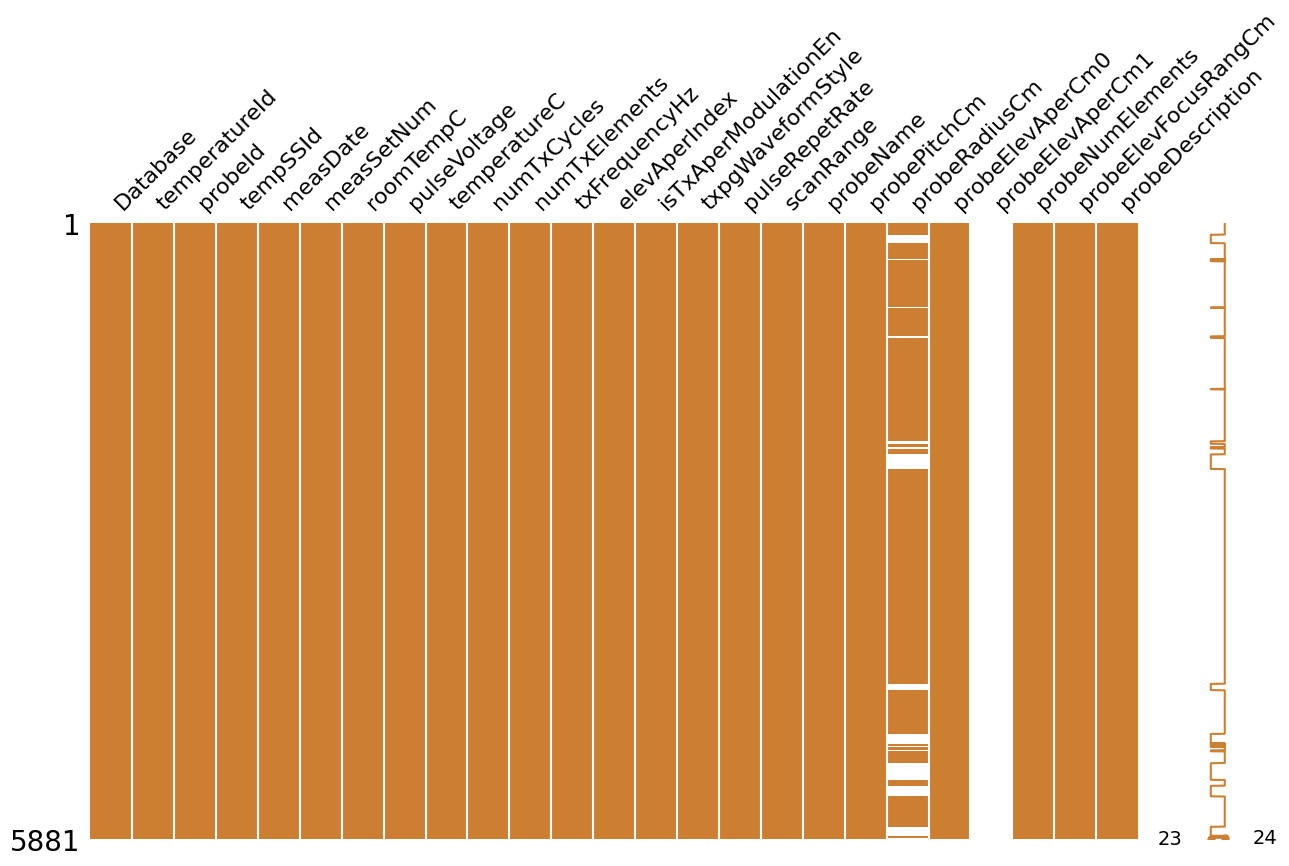

In [76]:
msno.matrix(df=AOP_data, figsize=(15,8), color=(0.8, 0.5, 0.2))

In [77]:
print(AOP_data["probeRadiusCm"].unique())
AOP_data["probeRadiusCm"].value_counts()

[6.23000002 1.48000002        nan 4.38000011 0.         1.08399999
 6.17799997 1.09000003 1.24259996 4.61999989 4.60300016 4.4000001
 6.10570002 1.32500005 6.25       6.07999992 1.11000001 1.01820004
 1.         1.46000004]


probeRadiusCm
0.0000    2065
1.4800     491
6.2300     322
4.6030     265
6.0800     257
1.0000     210
6.2500     207
4.3800     184
4.6200     183
6.1780     138
1.0840     136
1.3250     110
1.1100      95
1.0182      89
6.1057      70
1.0900      62
1.2426      61
1.4600      56
4.4000      50
Name: count, dtype: int64

<Axes: >

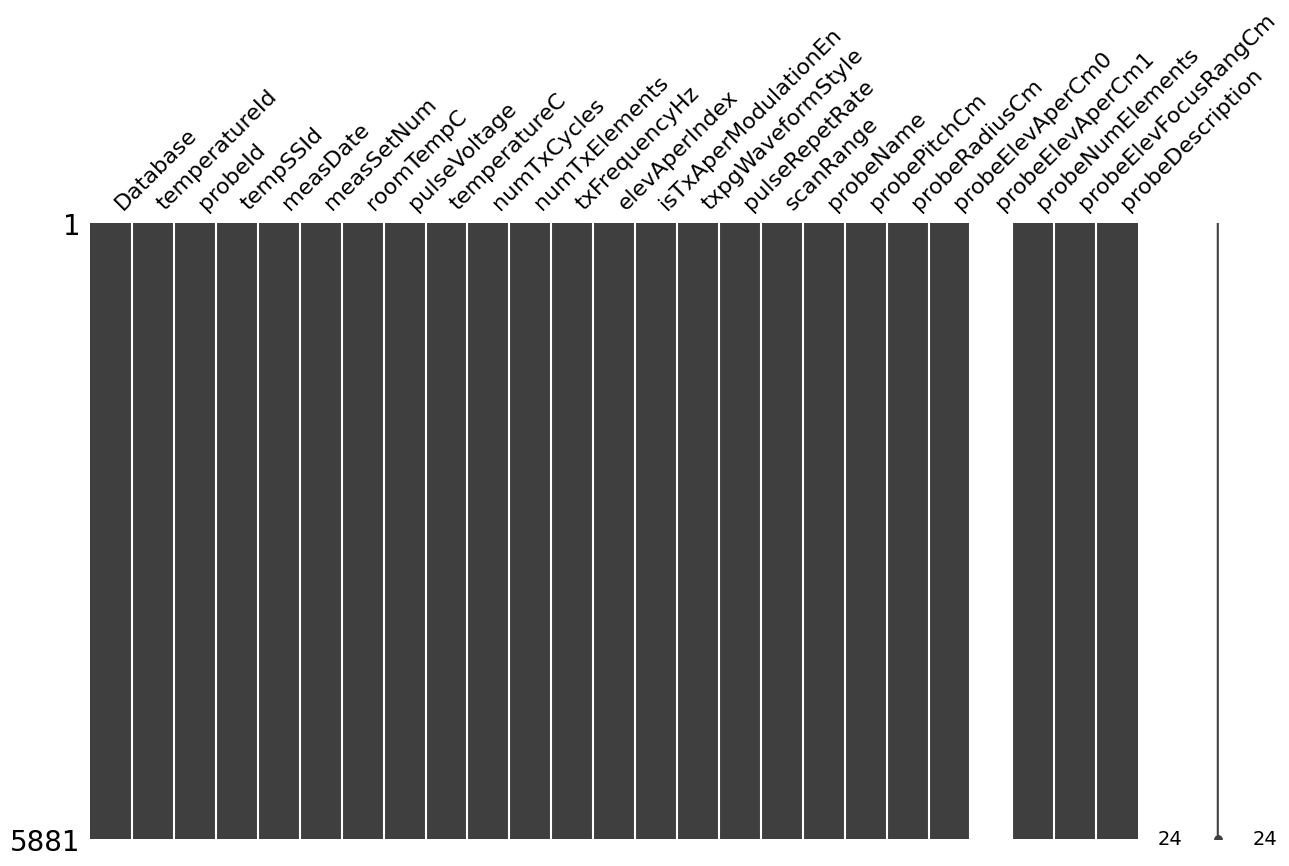

In [78]:
AOP_data["probeRadiusCm"].fillna(0, inplace=True)
msno.matrix(df=AOP_data, figsize=(15, 8))

---
#### 3) 데이터 parameter 전략을 어떻게 가지고 갈 것 인지?
- a) probeRadiusCm [NULL] 데이터 --> [0]으로 변경
- b) probeElevAperCm1 컬럼 데이터 전부 삭제 --> 전부 NULL 데이터이기에 삭제
- c) probeDescription 명확하게 구분화
      - Curved, Convex, Linear, Phased
- d) measDate는 필요없어 보임
- e) probeName 역시 필요없어 보임 --> probeId로 대체
- f) Target 데이터에 대한 고민이 필요해 보임.
      - temperatureC
      - roomTempC

<Axes: >

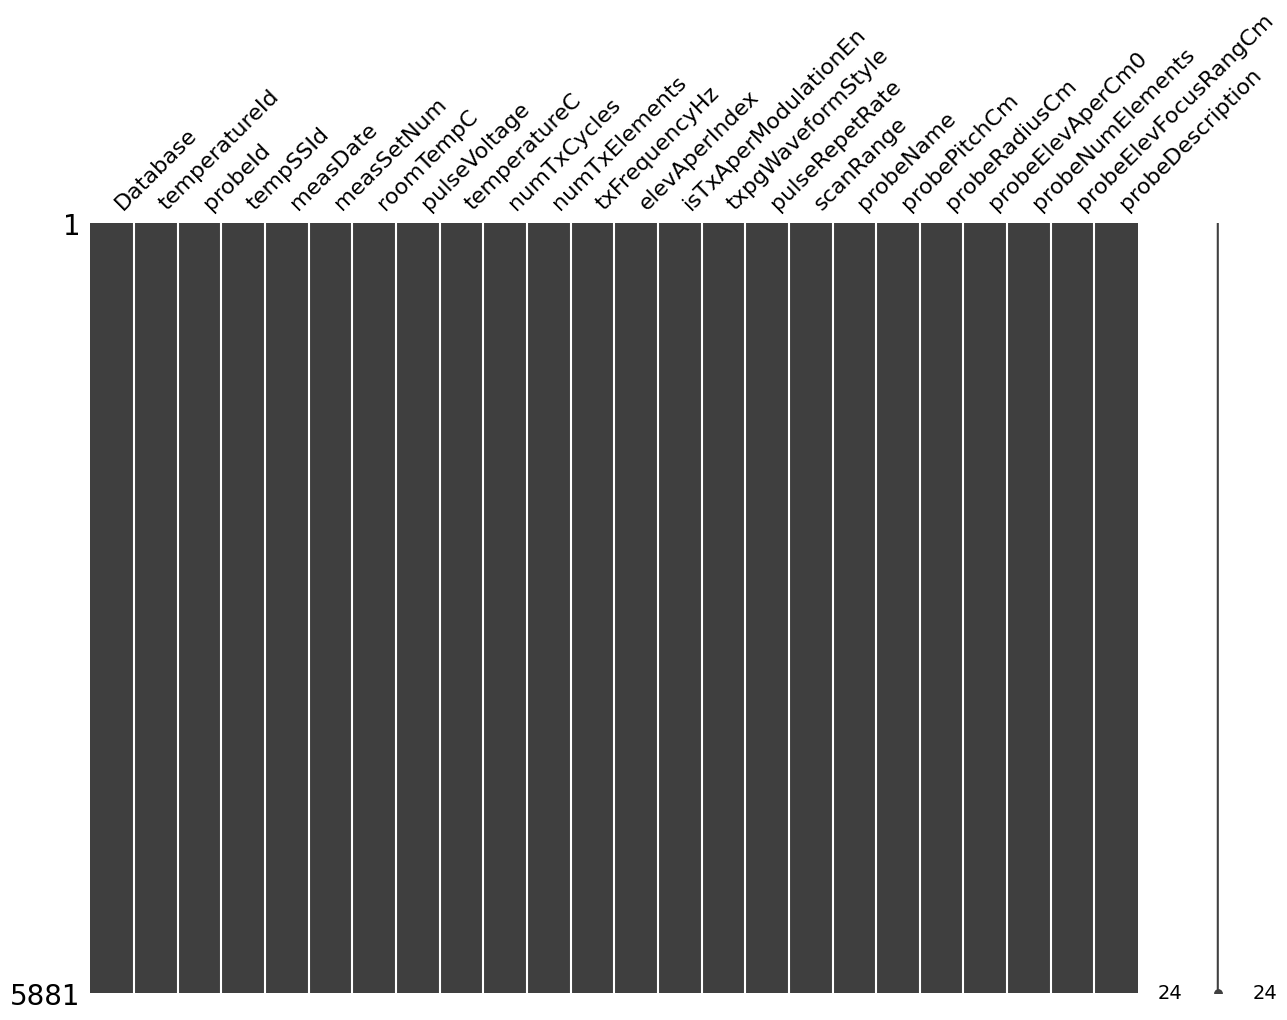

In [79]:
AOP_data = AOP_data.drop('probeElevAperCm1', axis=1)

msno.matrix(df=AOP_data, figsize=(15, 10))

#### c) probeDescription을 명확하게

In [80]:
print(AOP_data["probeDescription"].unique())
AOP_data["probeDescription"].value_counts()

['Convex' 'Phased' 'Curved' 'Linear' 'AcuNav_Phased' 'Phase']


probeDescription
Convex           1809
Linear           1578
Curved           1177
Phased           1044
Phase             169
AcuNav_Phased     104
Name: count, dtype: int64

In [81]:
AOP_data.loc[AOP_data["probeDescription"] == "Curved", "probeDescription"] = "Convex"
AOP_data.loc[AOP_data["probeDescription"] == "Phased", "probeDescription"] = "Phase"
AOP_data.loc[AOP_data["probeDescription"] == "AcuNav_Phased", "probeDescription"] = "Phase"

# 열의 데이터 종류 및 갯수 확인
column_name = 'probeDescription'  # 확인하고자 하는 열의 이름
unique_values = AOP_data[column_name].unique()
value_counts = AOP_data[column_name].value_counts()

print(f"{column_name} 열의 데이터 종류: {unique_values}")
print(f"{column_name} 열의 각 데이터 갯수:\n{value_counts}")
print(len(AOP_data[column_name]))

probeDescription 열의 데이터 종류: ['Convex' 'Phase' 'Linear']
probeDescription 열의 각 데이터 갯수:
probeDescription
Convex    2986
Linear    1578
Phase     1317
Name: count, dtype: int64
5881


---
#### d)-e) measDate / probeName 필요없어서 Drop

<Axes: >

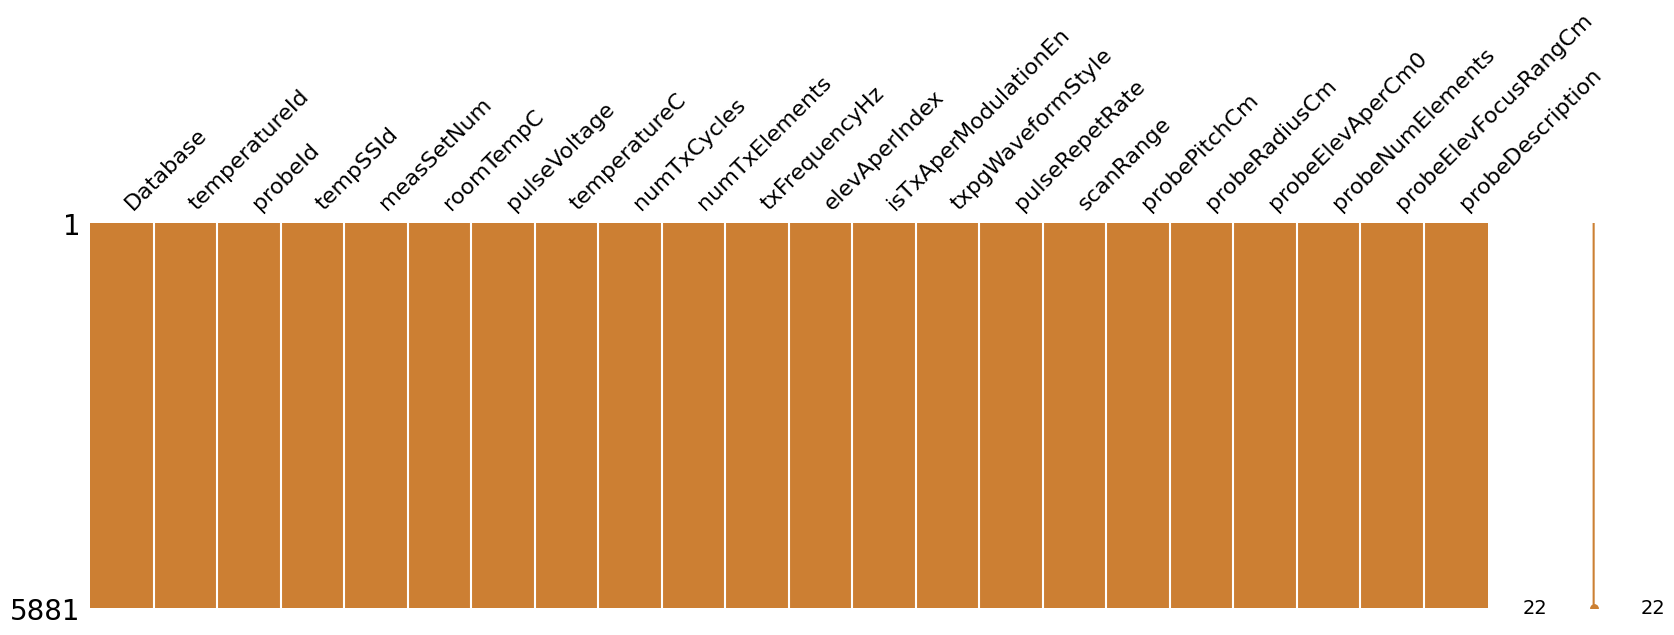

In [82]:
AOP_data = AOP_data.drop(["measDate", "probeName"], axis=1)
## Null 데이터를 시각화하여 보여준다.
msno.matrix(df=AOP_data, figsize=(20,5), color=(0.8, 0.5, 0.2))

#### target data review

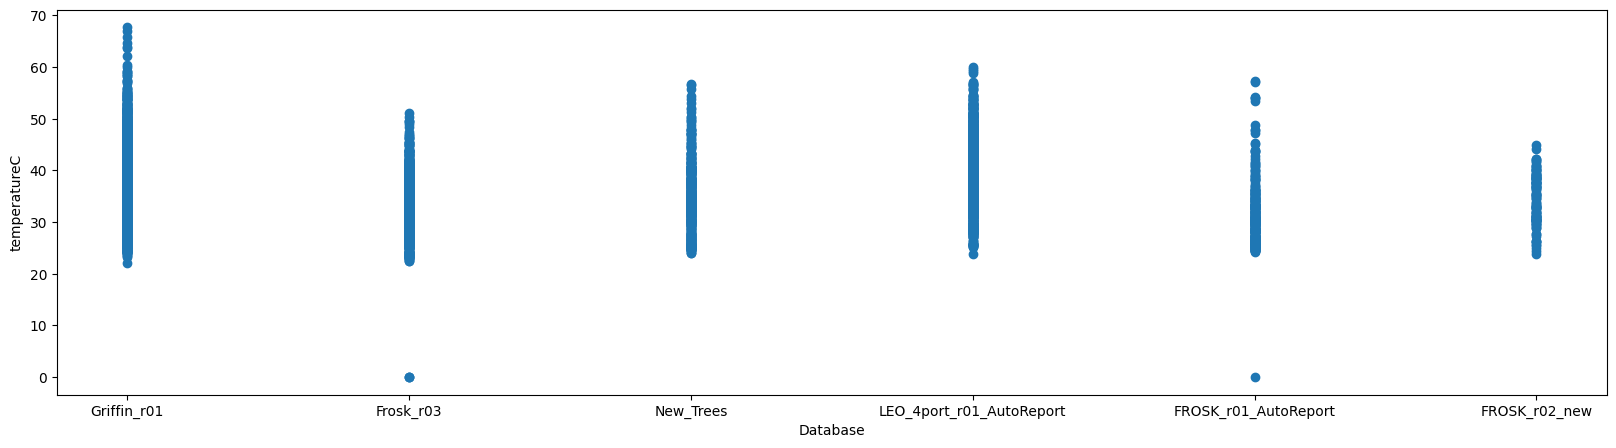

In [83]:
fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(AOP_data['Database'], AOP_data['temperatureC'])
plt.xlabel('Database', fontsize=10)
plt.ylabel('temperatureC', fontsize=10)
plt.show()

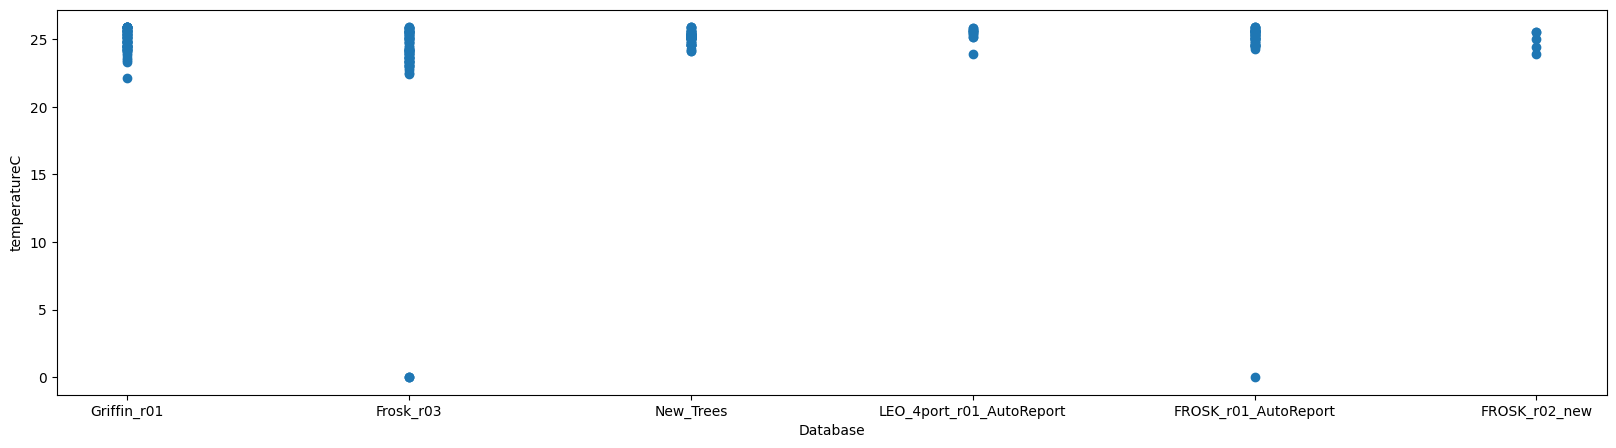

In [84]:
filter_data = AOP_data[AOP_data['temperatureC'] < 26]

fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(filter_data['Database'], filter_data['temperatureC'])
plt.xlabel('Database', fontsize=10)
plt.ylabel('temperatureC', fontsize=10)
plt.show()

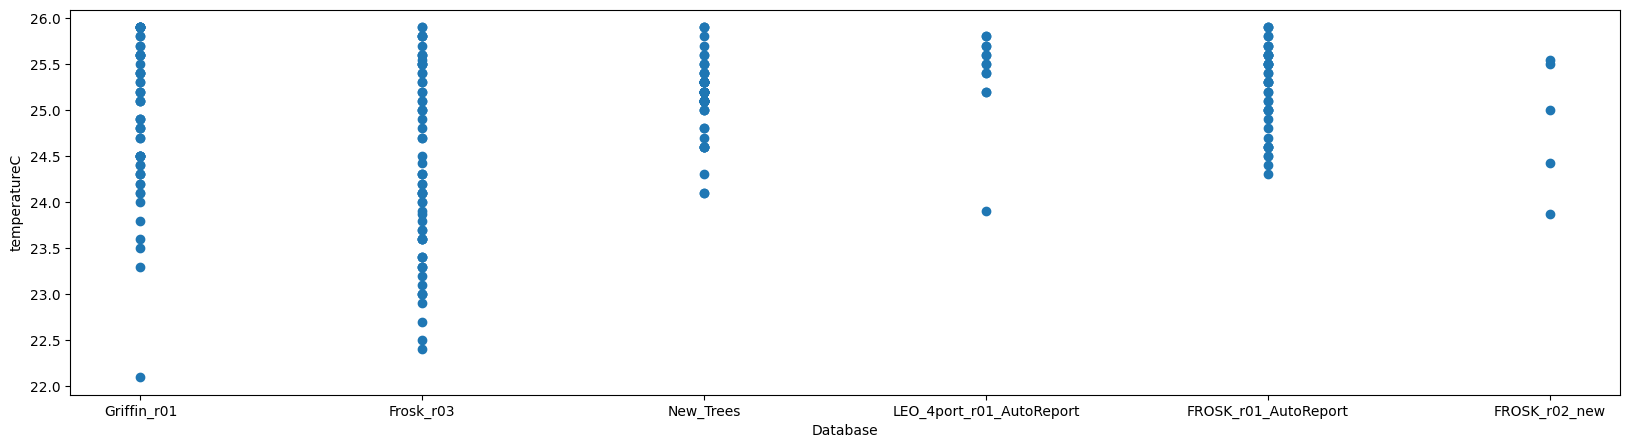

In [85]:
filter_data2 = filter_data[filter_data['temperatureC'] > 20]

fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(filter_data2['Database'], filter_data2['temperatureC'])
plt.xlabel('Database', fontsize=10)
plt.ylabel('temperatureC', fontsize=10)
plt.show()

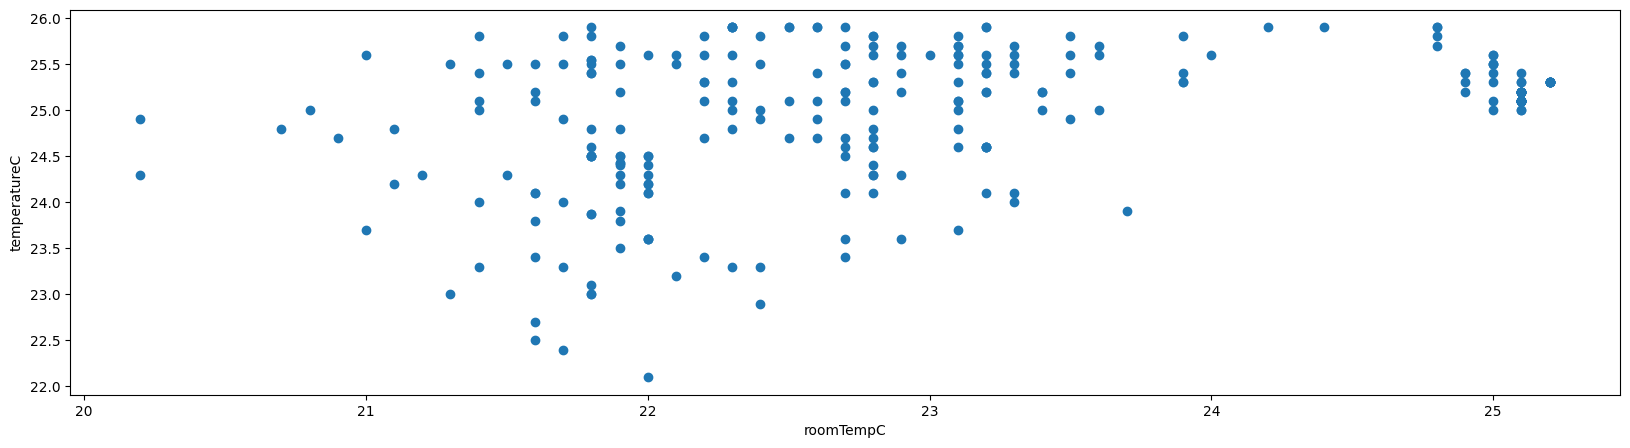

In [86]:
fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(filter_data2['roomTempC'], filter_data2['temperatureC'])
plt.xlabel('roomTempC', fontsize=10)
plt.ylabel('temperatureC', fontsize=10)
plt.show()

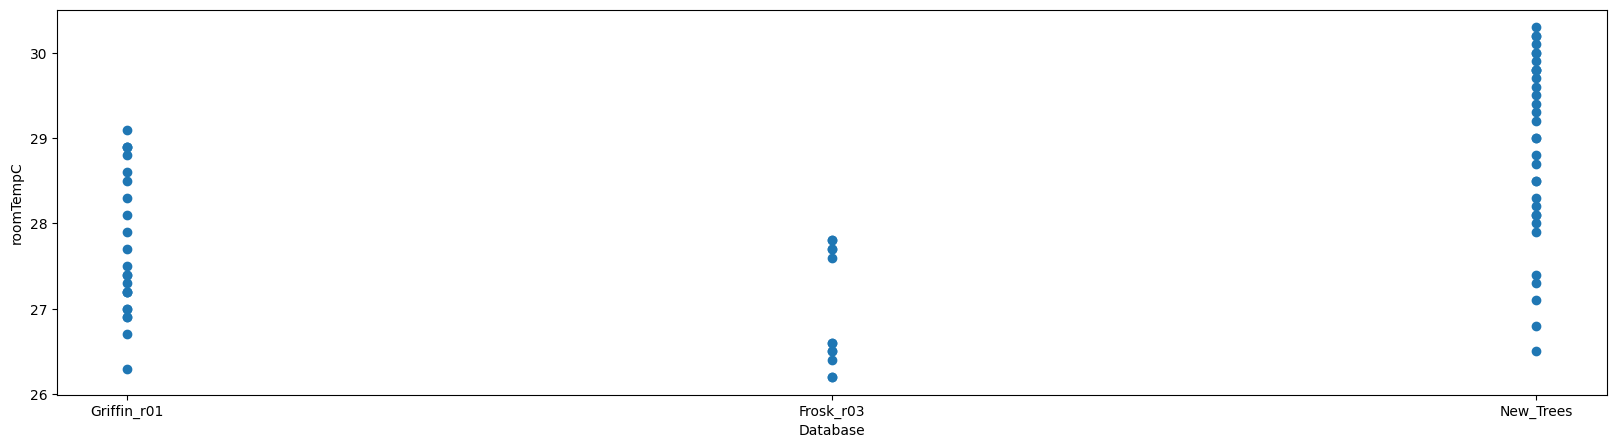

In [87]:
filter_data3 = AOP_data[AOP_data['roomTempC'] > 26]

fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(filter_data3['Database'], filter_data3['roomTempC'])
plt.xlabel('Database', fontsize=10)
plt.ylabel('roomTempC', fontsize=10)
plt.show()

#### 1) temperatureC = 0인 얘는 지운다.
#### 2) roomTempC > 26 애는 지운다.

In [88]:
AOP_data = AOP_data[AOP_data['temperatureC'] > 20]
AOP_data = AOP_data[AOP_data['roomTempC'] < 26]

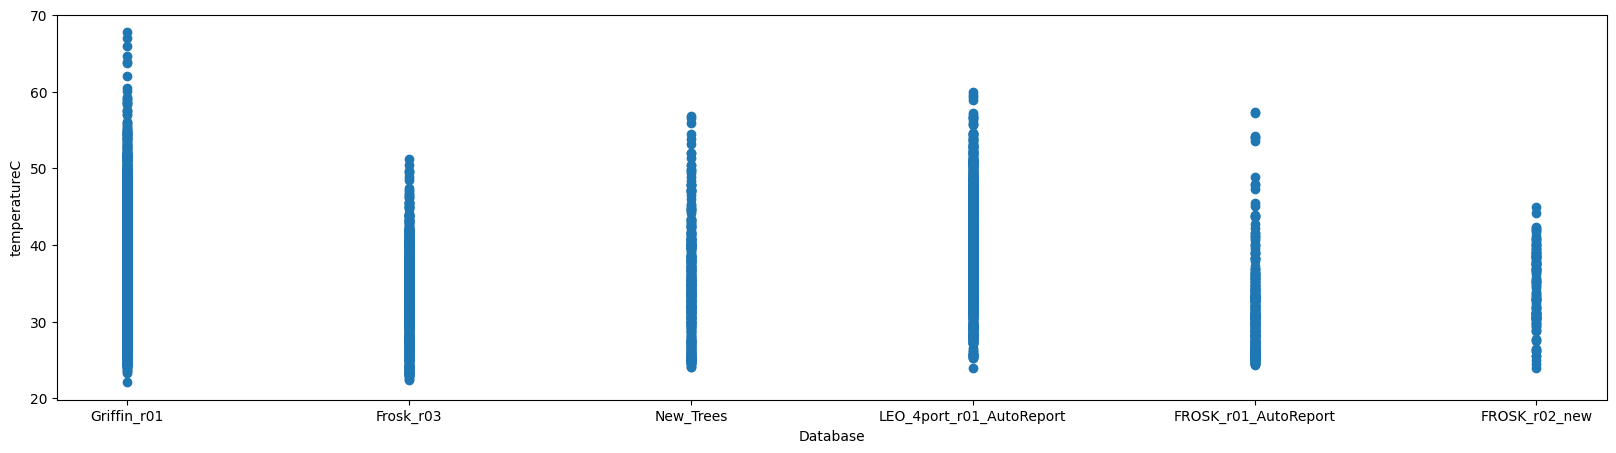

In [89]:
fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(AOP_data['Database'], AOP_data['temperatureC'])
plt.xlabel('Database', fontsize=10)
plt.ylabel('temperatureC', fontsize=10)
plt.show()

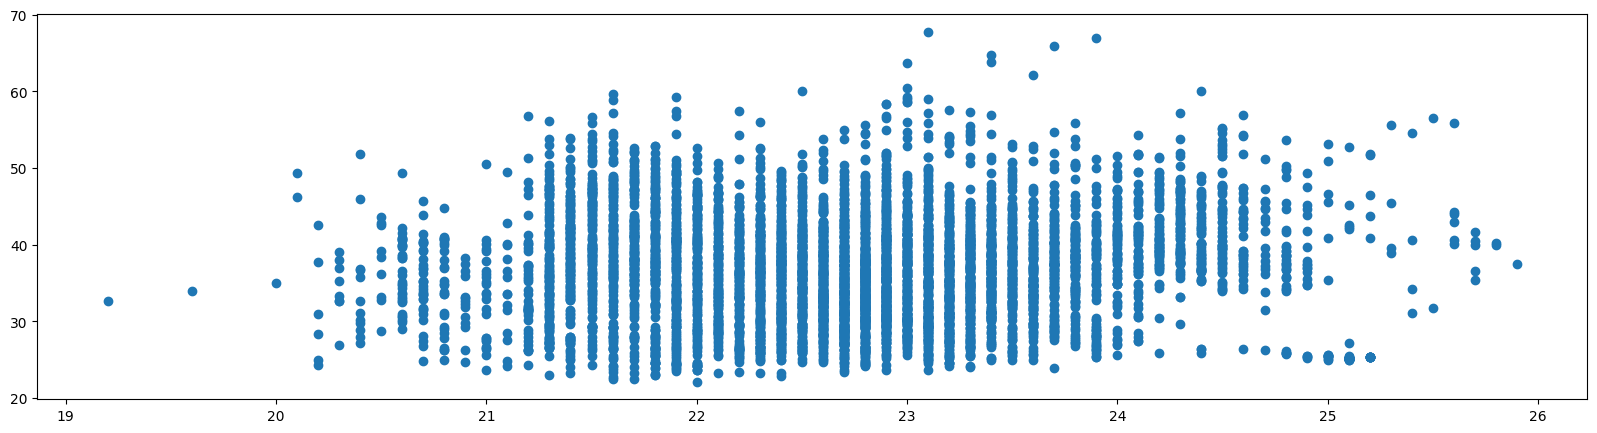

In [90]:
fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(AOP_data['roomTempC'], AOP_data['temperatureC'])
plt.show()

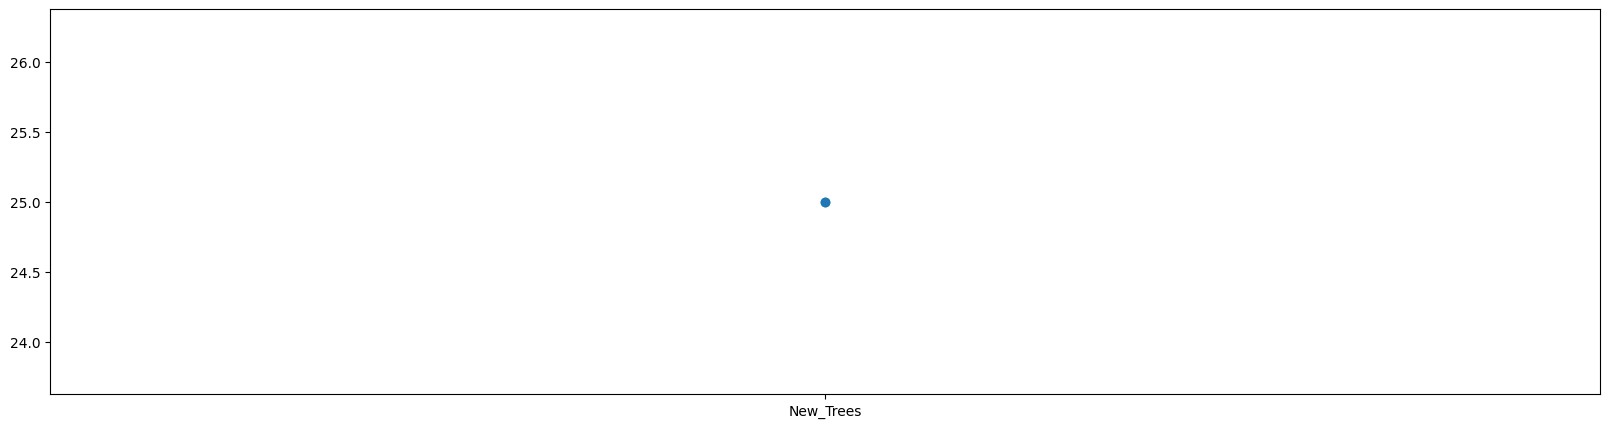

In [91]:
below_zero = AOP_data[(AOP_data['temperatureC']) - (AOP_data['roomTempC']) < 0]
fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(below_zero['Database'], below_zero['temperatureC'])
plt.show()

In [92]:
below_zero.head()

,Database,temperatureId,probeId,tempSSId,measSetNum,roomTempC,pulseVoltage,temperatureC,numTxCycles,numTxElements,...,isTxAperModulationEn,txpgWaveformStyle,pulseRepetRate,scanRange,probePitchCm,probeRadiusCm,probeElevAperCm0,probeNumElements,probeElevFocusRangCm,probeDescription
156,New_Trees,303,11711157,146,3,25.1,57.709999,25.0,1.0,9,...,1,1,1250.000000,2.17697,0.0484,6.08,1.3,128.0,6.0,Convex
158,New_Trees,305,11711157,146,3,25.1,57.709999,25.0,1.0,9,...,1,1,1996.810059,6.22876,0.0484,6.08,1.3,128.0,6.0,Convex


In [93]:
AOP_data = AOP_data[(AOP_data['temperatureC']) - (AOP_data['roomTempC']) > 0]

In [94]:
AOP_data.shape

(5789, 22)

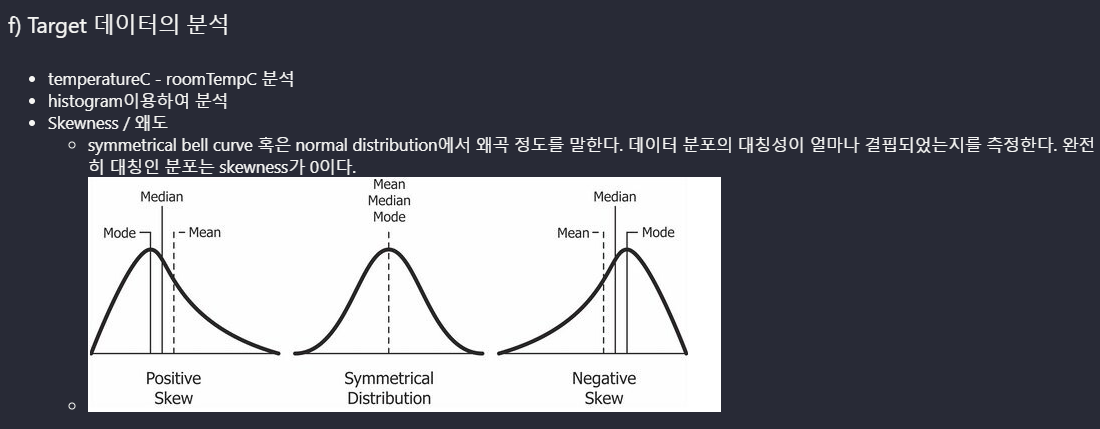

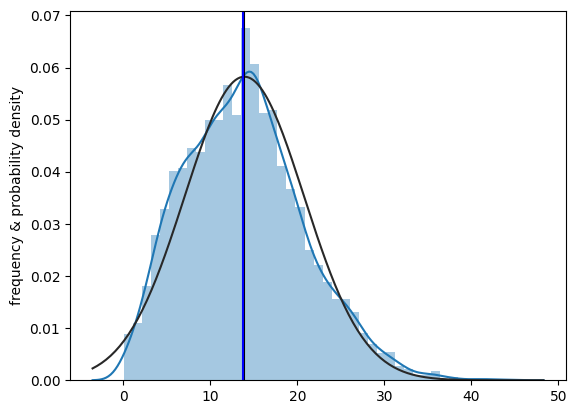

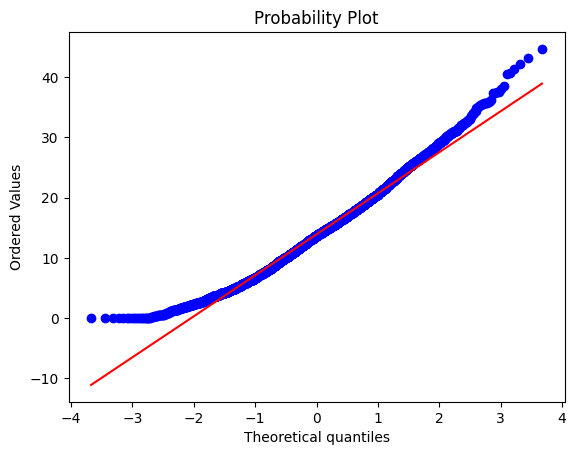

0.4574240442307344
0.11165776469268662


In [95]:
temperatureRise = AOP_data['temperatureC'] - AOP_data['roomTempC']
sns.distplot(temperatureRise, fit=norm)

(mu, sigma) = norm.fit(temperatureRise)
plt.ylabel('frequency & probability density')

plt.axvline(temperatureRise.mean(), color='black')
plt.axvline(temperatureRise.median(), color='blue')

#QQ-plot
fig = plt.figure()
pro = stats.probplot(temperatureRise, plot=plt)
plt.show()

print(temperatureRise.skew())
print(temperatureRise.kurt())

In [96]:
AOP_data.shape

(5789, 22)

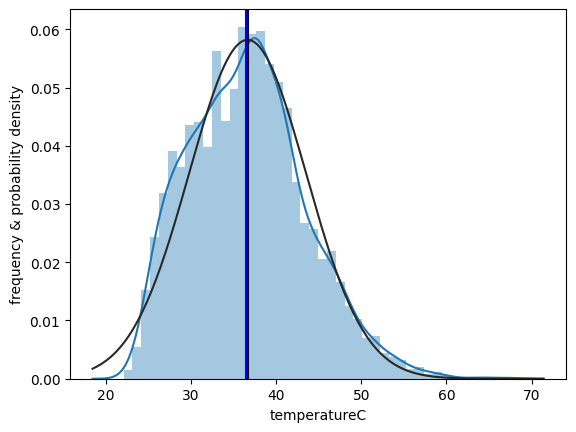

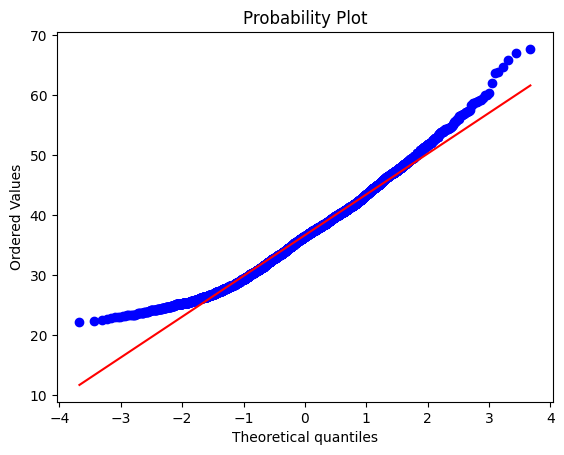

0.44895631940583147
0.09958499306526791


In [97]:
temperature = AOP_data['temperatureC']
sns.distplot(temperature, fit=norm)

(mu, sigma) = norm.fit(temperature)
plt.ylabel('frequency & probability density')

plt.axvline(temperature.mean(), color='black')
plt.axvline(temperature.median(), color='blue')

#QQ-plot
fig = plt.figure()
pro = stats.probplot(temperature, plot=plt)
plt.show()

print(temperature.skew())
print(temperature.kurt())

---

log transform 변환하여 확인하기

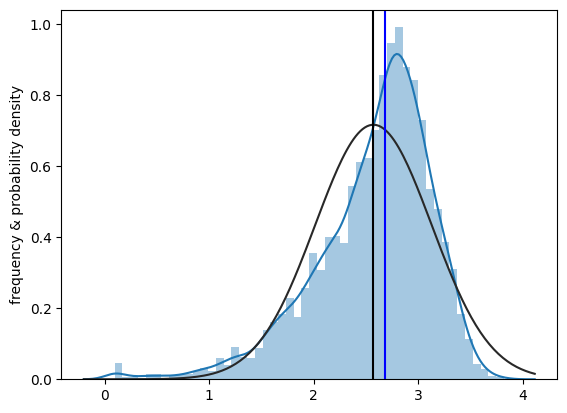

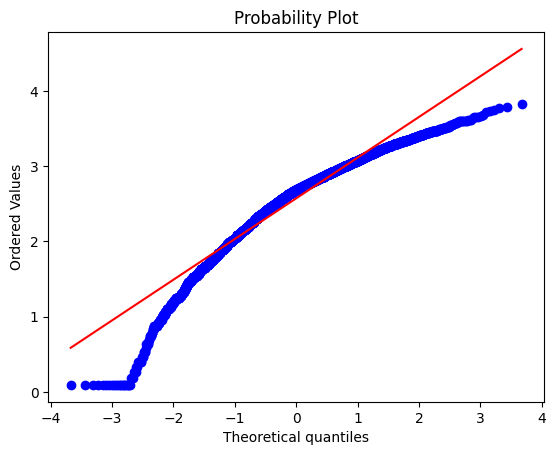

-1.109302326074275
1.9004140163331749


In [98]:
logTempRise = np.log1p(temperatureRise)

sns.distplot(logTempRise, fit=norm)

(mu, sigma) = norm.fit(logTempRise)
plt.ylabel('frequency & probability density')

plt.axvline(logTempRise.mean(), color='black')
plt.axvline(logTempRise.median(), color='blue')

#QQ-plot
fig = plt.figure()
pro = stats.probplot(logTempRise, plot=plt)
plt.show()

print(logTempRise.skew())
print(logTempRise.kurt())

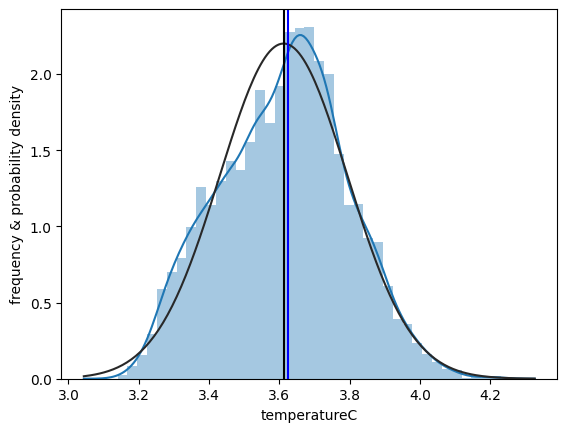

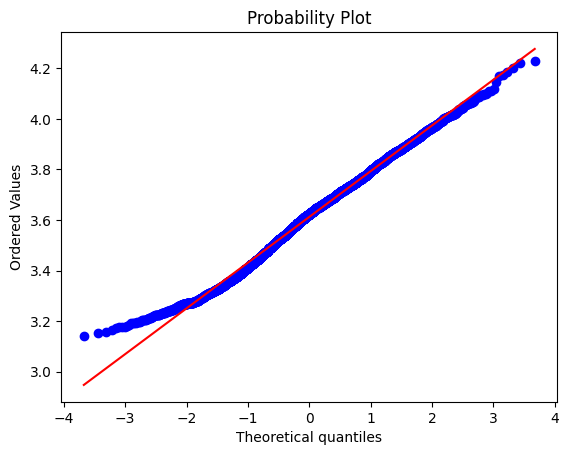

-0.006013277047209828
-0.4263062008306777


In [99]:
logTemp = np.log1p(temperature)

sns.distplot(logTemp, fit=norm)

(mu, sigma) = norm.fit(logTemp)
plt.ylabel('frequency & probability density')

plt.axvline(logTemp.mean(), color='black')
plt.axvline(logTemp.median(), color='blue')

#QQ-plot
fig = plt.figure()
pro = stats.probplot(logTemp, plot=plt)
plt.show()

print(logTemp.skew())
print(logTemp.kurt())

In [100]:
AOP_data.shape

(5789, 22)

In [101]:
AOP_data.describe

<bound method NDFrame.describe of           Database  temperatureId   probeId  tempSSId  measSetNum  roomTempC  \
0      Griffin_r01            325  11268278       147           4  22.299999   
1      Griffin_r01            327  11268278       147           4  22.400000   
2      Griffin_r01            329  11268278       147           4  22.799999   
3      Griffin_r01            332  11268278       147           4  23.000000   
4      Griffin_r01            334  11268278       147           4  23.100000   
..             ...            ...       ...       ...         ...        ...   
113  FROSK_r02_new           1302       231      1276           3  21.400000   
114  FROSK_r02_new           1303       231      1276           3  21.400000   
115  FROSK_r02_new           1304       231      1276           3  21.400000   
116  FROSK_r02_new           1305       231      1276           3  21.400000   
117  FROSK_r02_new           1306       231      1276           3  21.400000   

     

#### 1MHz일 경우가 CW인데, 이 데이터를 어떻게 처리할지

[2687.         1810.52001953 1219.94995117 ... 1505.69995117 5387.93017578
 3434.07006836]
pulseRepetRate
3.000000e+04    75
2.000000e+06    43
5.000000e+06    40
4.000000e+03    31
5.000000e+03    29
                ..
1.885370e+03     1
2.828050e+03     1
8.668500e+02     1
9.819300e+02     1
3.434070e+03     1
Name: count, Length: 3665, dtype: int64


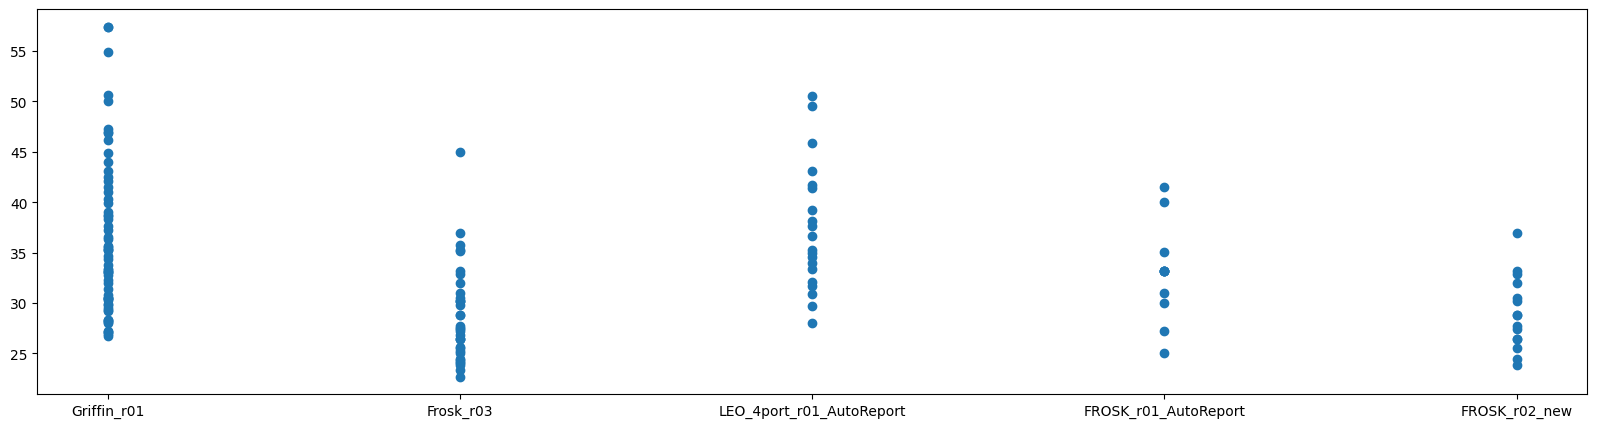

In [102]:
print(AOP_data['pulseRepetRate'].unique())
print(AOP_data['pulseRepetRate'].value_counts())

PRF_data = AOP_data[AOP_data['pulseRepetRate'] > 1000000]

fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(PRF_data['Database'], PRF_data['temperatureC'])
plt.show()


In [103]:
print(AOP_data.shape)

AOP_data = AOP_data[AOP_data['pulseRepetRate'] < 1000000]
print(AOP_data.shape)

(5789, 22)
(5643, 22)


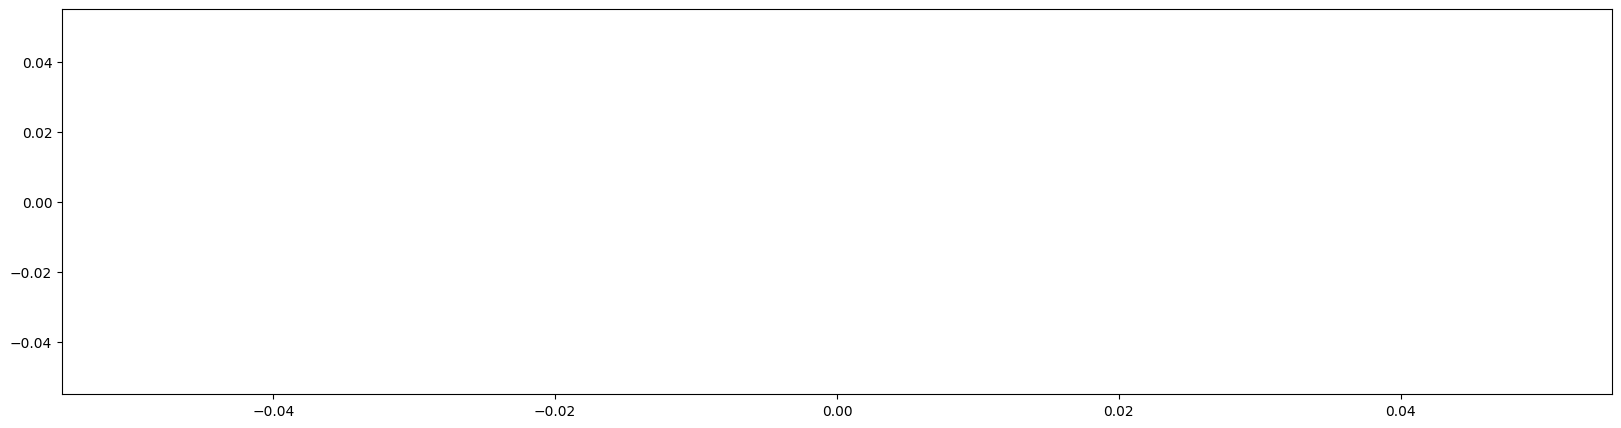

In [105]:
below_100 = AOP_data[AOP_data['pulseRepetRate'] < 100]

fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(below_100['Database'], below_100['temperatureC'])
plt.show()

#### Target vs. Energy

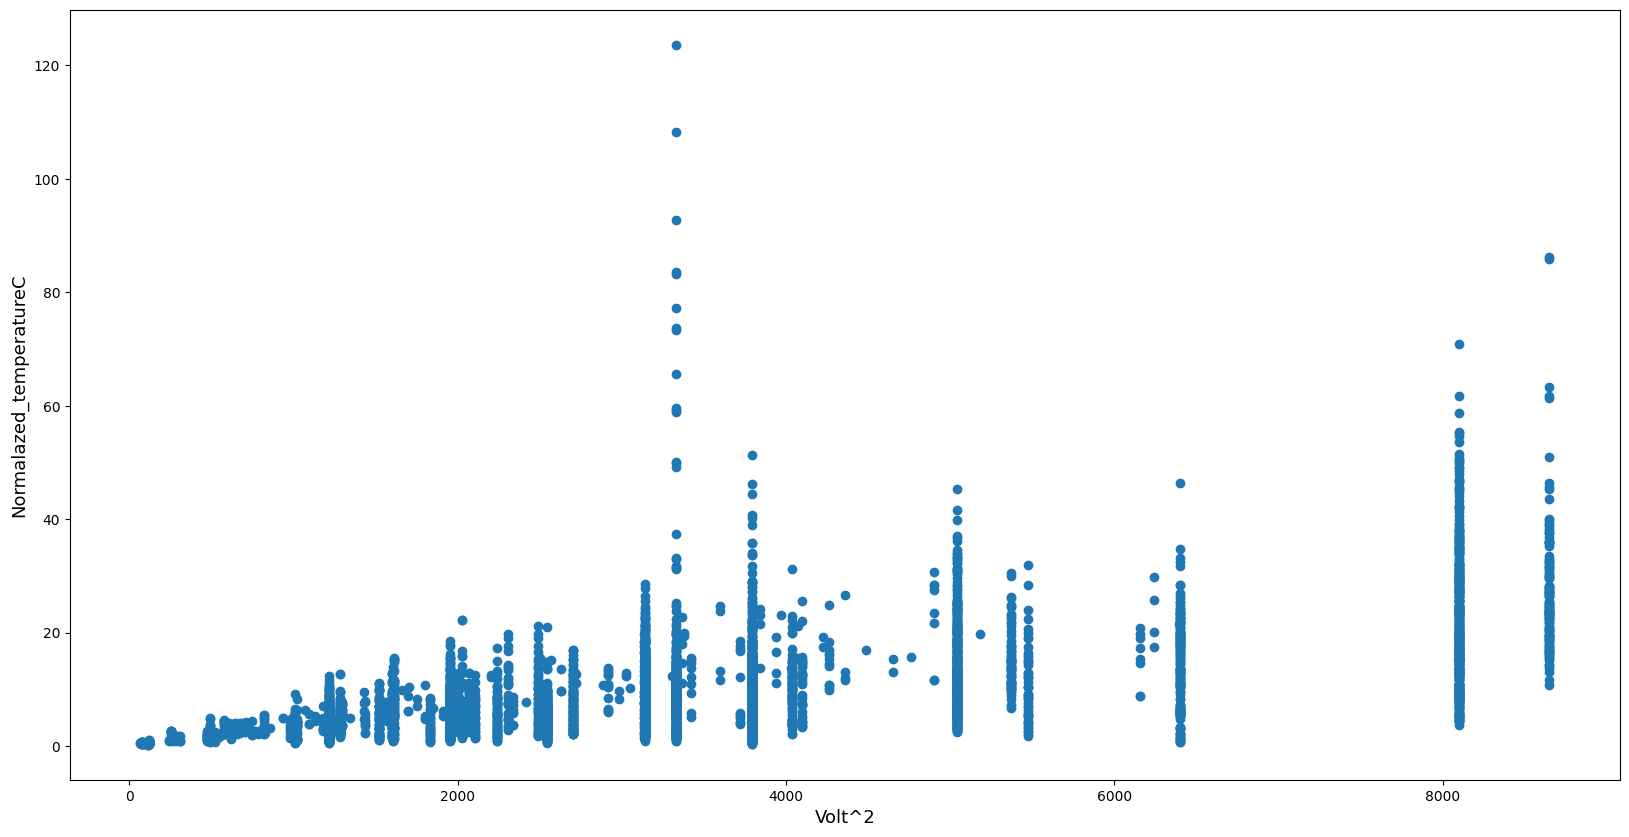

In [108]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x=AOP_data['pulseVoltage'] * AOP_data['pulseVoltage'],
            y=AOP_data['temperatureC'] / (AOP_data['numTxCycles'] * (AOP_data['pulseRepetRate']/1000)))
plt.xlabel('Volt^2', fontsize=13)
plt.ylabel('Normalazed_temperatureC', fontsize=13)

plt.show()

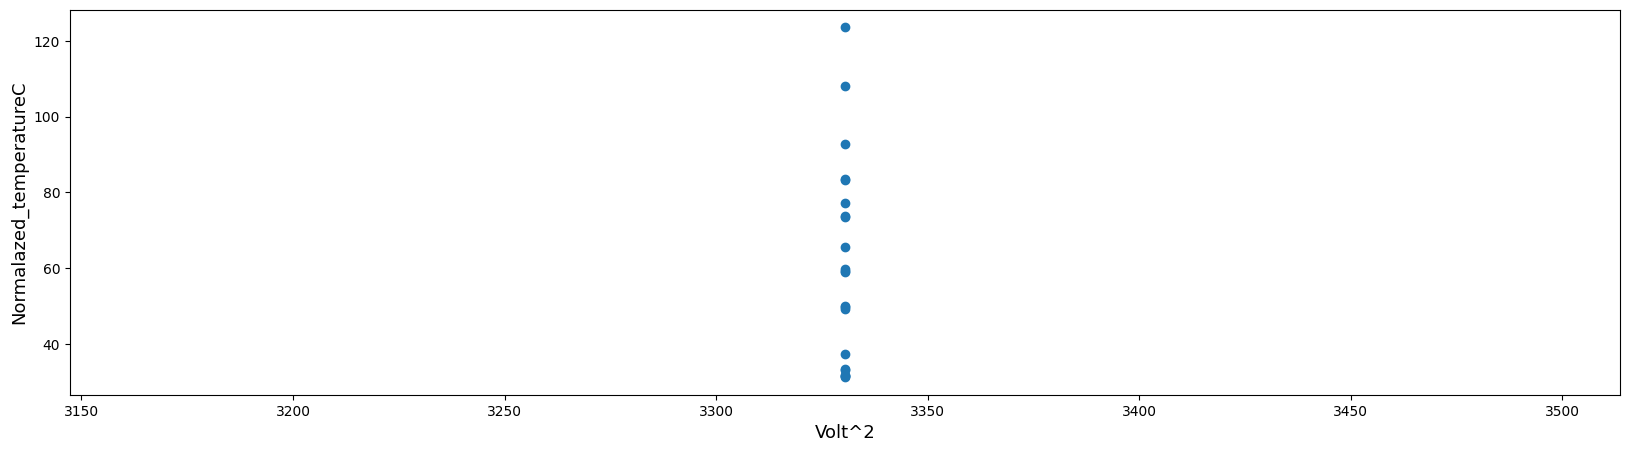

In [109]:
AOP_data['volt2'] = AOP_data['pulseVoltage'] * AOP_data['pulseVoltage']
AOP_data['normal_Temp'] = AOP_data['temperatureC'] / (AOP_data['numTxCycles'] * (AOP_data['pulseRepetRate']/1000))

outlier = AOP_data[(AOP_data['volt2'] < 3500) & (AOP_data['normal_Temp'] > 30)]

fig, axs = plt.subplots(figsize=(20, 5))
axs.scatter(x = outlier['volt2'], y = outlier['normal_Temp'])
plt.xlabel('Volt^2', fontsize=13)
plt.ylabel('Normalazed_temperatureC', fontsize=13)

plt.show()

In [110]:
outlier.head(30)

,Database,temperatureId,probeId,tempSSId,measSetNum,roomTempC,pulseVoltage,temperatureC,numTxCycles,numTxElements,...,pulseRepetRate,scanRange,probePitchCm,probeRadiusCm,probeElevAperCm0,probeNumElements,probeElevFocusRangCm,probeDescription,volt2,normal_Temp
148,New_Trees,293,11711157,146,4,25.000000,57.709999,25.400000,1.0,86,...,770.510010,0.000000,0.0484,6.08,1.3,128.0,6.0,Convex,3330.443994,32.965178
153,New_Trees,299,11711157,147,4,25.000000,57.709999,25.600000,1.0,86,...,770.510010,0.000000,0.0484,6.08,1.3,128.0,6.0,Convex,3330.443994,33.224747
155,New_Trees,302,11711157,146,3,25.000000,57.709999,25.100000,1.0,9,...,799.739990,0.315285,0.0484,6.08,1.3,128.0,6.0,Convex,3330.443994,31.385201
163,New_Trees,310,11711157,146,3,25.100000,57.709999,25.200001,1.0,43,...,425.890015,0.315285,0.0484,6.08,1.3,128.0,6.0,Convex,3330.443994,59.170208
164,New_Trees,311,11711157,146,3,25.100000,57.709999,25.200001,1.0,43,...,505.660004,2.176970,0.0484,6.08,1.3,128.0,6.0,Convex,3330.443994,49.835859
167,New_Trees,314,11711157,146,3,25.100000,57.709999,25.200001,1.0,64,...,302.739990,0.315285,0.0484,6.08,1.3,128.0,6.0,Convex,3330.443994,83.239749
168,New_Trees,315,11711157,146,3,25.100000,57.709999,25.200001,1.0,64,...,343.119995,2.176970,0.0484,6.08,1.3,128.0,6.0,Convex,3330.443994,73.443696
175,New_Trees,322,11711157,147,3,25.100000,57.709999,25.200001,1.0,9,...,799.739990,0.315285,0.0484,6.08,1.3,128.0,6.0,Convex,3330.443994,31.510242
179,New_Trees,326,11711157,147,3,25.100000,57.709999,25.299999,1.0,22,...,385.450012,0.315285,0.0484,6.08,1.3,128.0,6.0,Convex,3330.443994,65.637562
180,New_Trees,327,11711157,147,3,25.100000,57.709999,25.200001,1.0,22,...,794.659973,2.176970,0.0484,6.08,1.3,128.0,6.0,Convex,3330.443994,31.711677


In [111]:
below_3degs = AOP_data[AOP_data['temperatureC'] - AOP_data['roomTempC'] > 3]
print(below_3degs.shape)
below_2degs = AOP_data[AOP_data['temperatureC'] - AOP_data['roomTempC'] > 2]
print(below_2degs.shape)


(5447, 24)
(5541, 24)


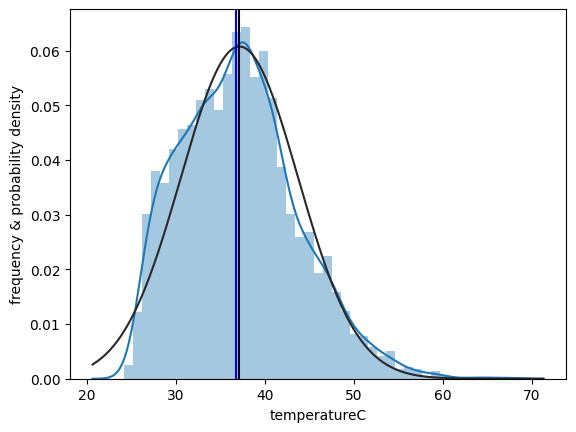

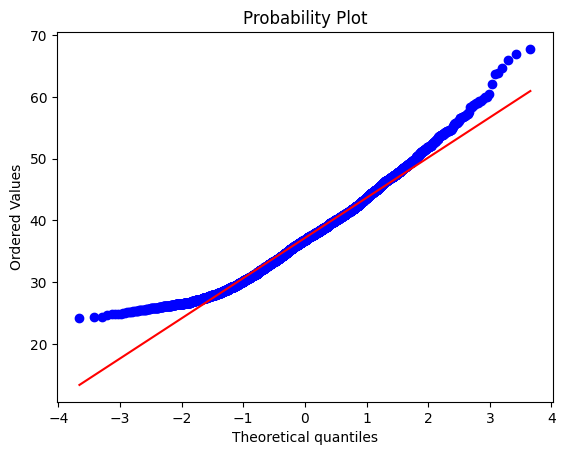

0.528752839706979
0.21589823211869108


In [112]:
temperature = below_3degs['temperatureC']
sns.distplot(temperature, fit=norm)

(mu, sigma) = norm.fit(temperature)
plt.ylabel('frequency & probability density')

plt.axvline(temperature.mean(), color='black')
plt.axvline(temperature.median(), color='blue')

#QQ-plot
fig = plt.figure()
pro = stats.probplot(temperature, plot=plt)
plt.show()

print(temperature.skew())
print(temperature.kurt())

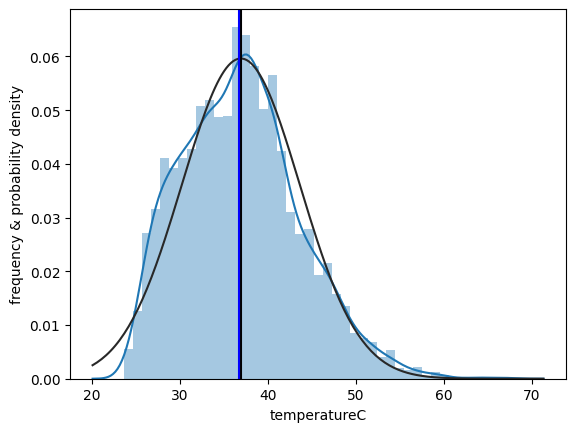

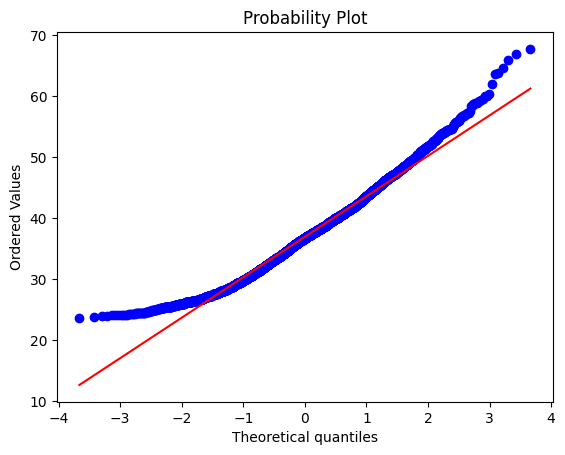

0.486299150209019
0.16113544135346602


In [113]:
temperature = below_2degs['temperatureC']
sns.distplot(temperature, fit=norm)

(mu, sigma) = norm.fit(temperature)
plt.ylabel('frequency & probability density')

plt.axvline(temperature.mean(), color='black')
plt.axvline(temperature.median(), color='blue')

#QQ-plot
fig = plt.figure()
pro = stats.probplot(temperature, plot=plt)
plt.show()

print(temperature.skew())
print(temperature.kurt())

In [114]:
AOP_data = AOP_data[AOP_data['temperatureC'] - AOP_data['roomTempC'] > 2]

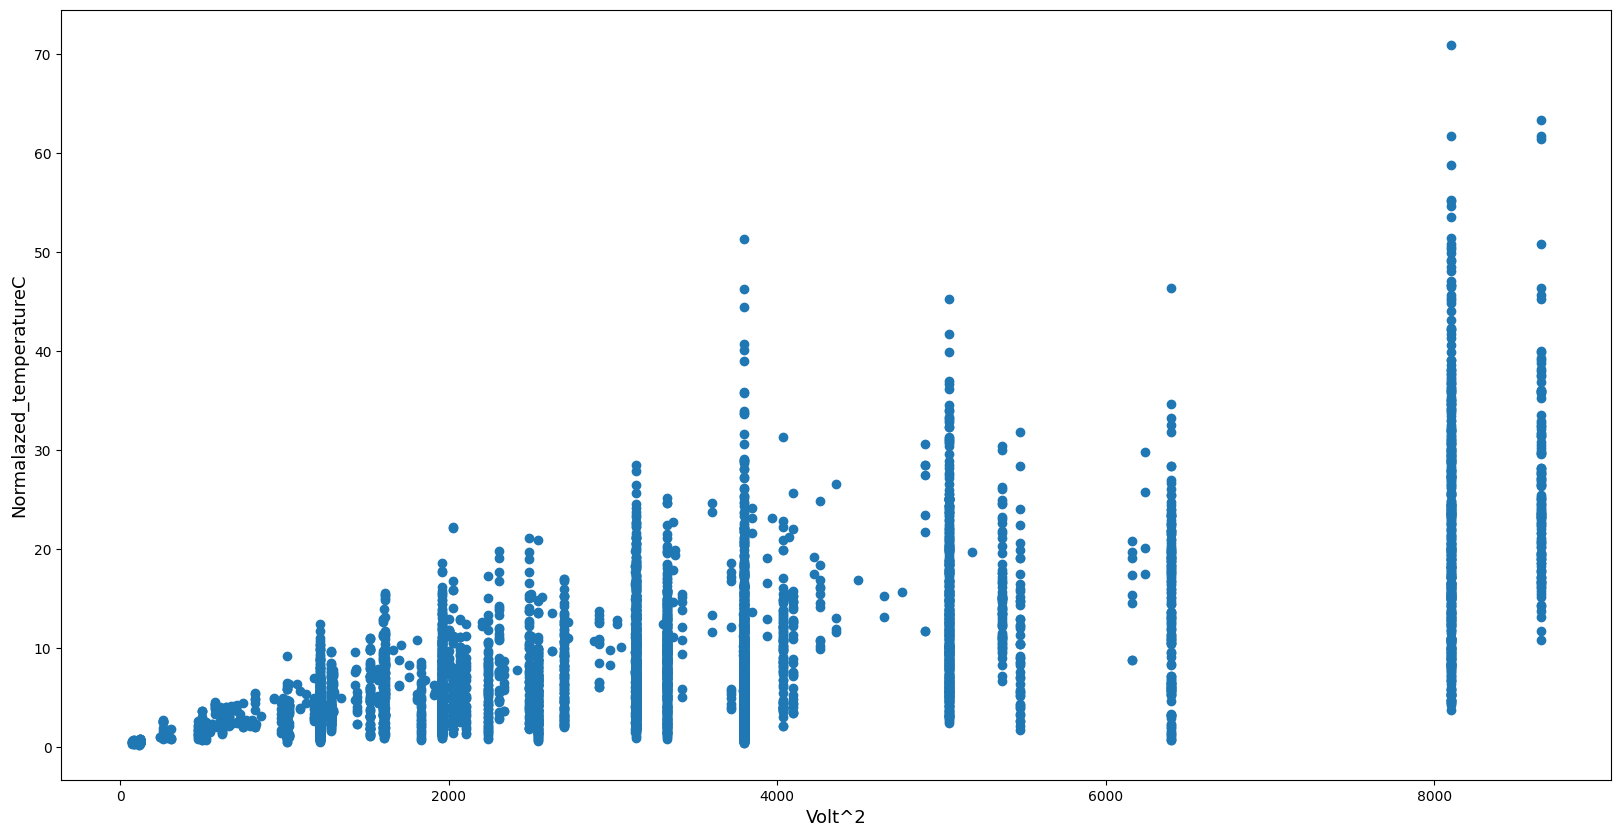

In [115]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x=AOP_data['pulseVoltage'] * AOP_data['pulseVoltage'],
            y=AOP_data['temperatureC'] / (AOP_data['numTxCycles'] * (AOP_data['pulseRepetRate']/1000)))
plt.xlabel('Volt^2', fontsize=13)
plt.ylabel('Normalazed_temperatureC', fontsize=13)

plt.show()

#### temperatureC > 0 이상
#### roomTempC < 26 이하
#### temperatureRise > 2도 이상만

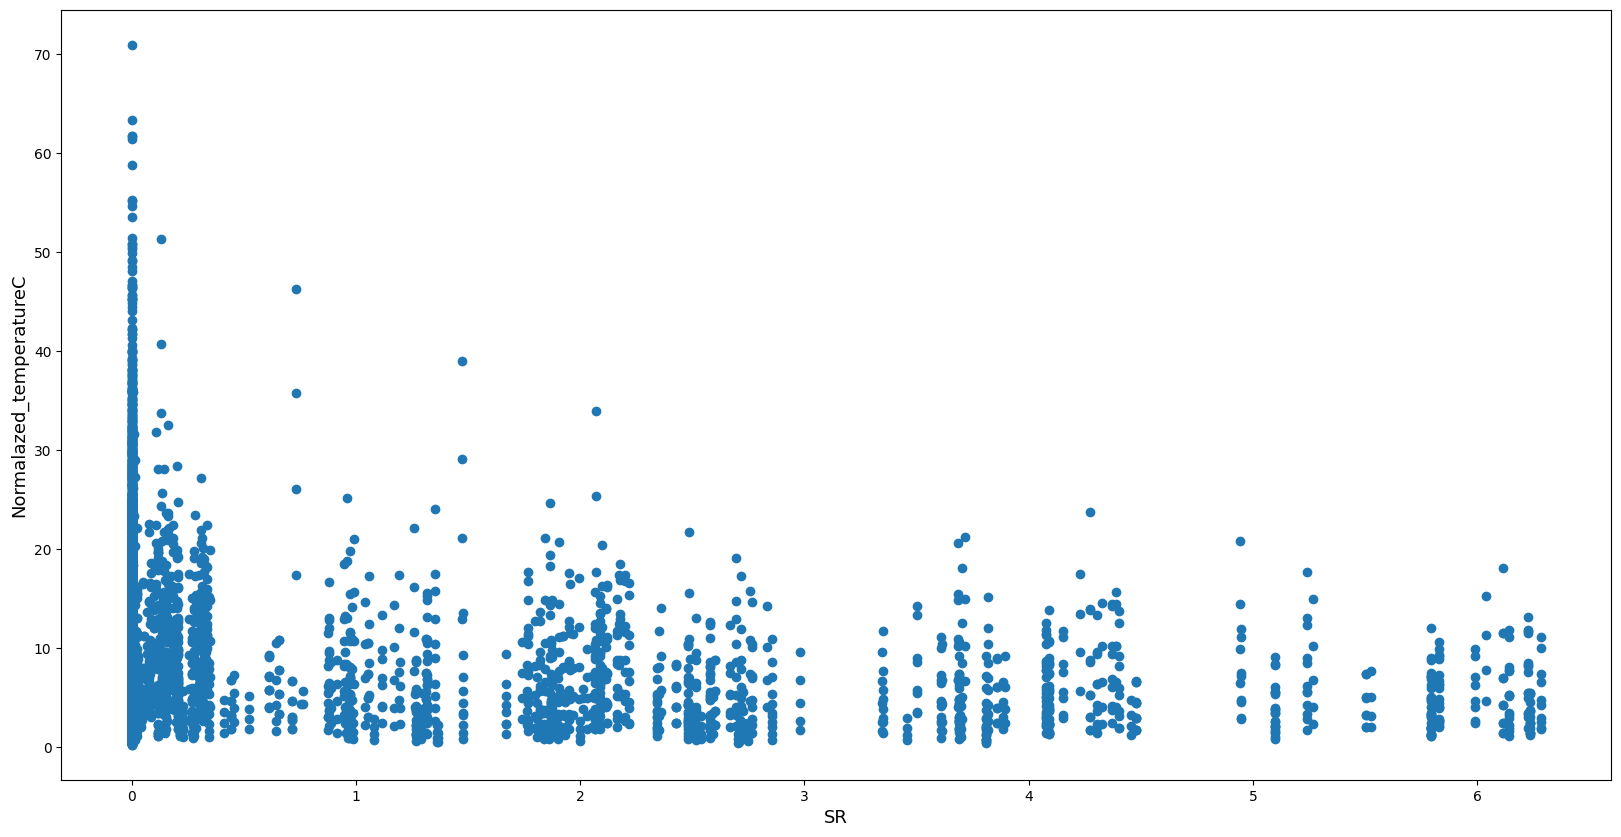

In [116]:
fig, axs = plt.subplots(figsize=(20, 10))
axs.scatter(x=AOP_data['scanRange'],
            y=AOP_data['temperatureC'] / (AOP_data['numTxCycles'] * (AOP_data['pulseRepetRate']/1000)))
plt.xlabel('SR', fontsize=13)
plt.ylabel('Normalazed_temperatureC', fontsize=13)

plt.show()